<a href="https://colab.research.google.com/github/christine127/Portfolio_Recommendation_Project/blob/main/%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mlxtend --upgrade

     |████████████████████████████████| 1.3 MB 5.2 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import mlxtend

In [3]:
path ='/content/drive/MyDrive/소회의실 프로젝트/전처리_완료/'
file = pd.read_csv(path + '원본_brif_공모수정.csv', encoding ='cp949')
customer_info = pd.read_csv(path+'클러스터링_고객구분코드.csv' )

sample_file = pd.read_csv(path+'원본_sample100.csv' , encoding='cp949')
sample_info = pd.read_csv(path+'sample_cluster.csv' )


In [4]:
## 거래횟수 상위 10 종목 제외

# stock = file.groupby('상품명')['상품명'].count().sort_values(ascending = False)[:10]
# stock= pd.DataFrame(stock).rename(columns = {'상품명':'count'}).reset_index()

# file = file.loc[~file['상품명'].isin(stock['상품명'])]
# sample_file = sample_file.loc[~sample_file['상품명'].isin(stock['상품명'])]

In [5]:
customer_info

,고객구분코드,동일나이군구분코드,총매수금액,총매수수량,업종개수,large_cap,medium_cap,small_cap,large_cap_period,PER,PBR,ROE,EPS,ATR_7,cluster
0,A000973,0.0,-0.188454,-0.220015,-0.8,0.798295,-0.550775,-0.356546,-0.391667,-0.137600,-0.399572,1.284474,4.487079,2.107561,2
1,A00013780,0.0,1.012451,0.214668,-0.6,0.520765,-0.066435,-0.356546,-0.386667,4.516943,3.510591,0.905693,0.058723,2.319570,4
2,A0009975,1.0,-0.298310,-0.216960,-1.0,-0.629170,1.940399,-0.356546,-0.666667,-0.397684,-0.403039,-0.469574,1.924817,-0.440116,2
3,A00012551,0.0,1.202118,3.247517,1.8,-0.629170,0.539688,0.959189,-0.666667,0.397516,-0.348721,1.578465,-0.148041,-0.462189,2
4,A000706,-0.5,-0.229829,1.138273,0.0,-0.165281,-0.550775,1.223045,-0.666667,-0.335217,-0.451078,-0.404407,0.000165,-0.585511,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7933,A00011326,0.0,0.207308,3.671505,-0.2,0.261436,-0.152156,0.149091,0.283333,-0.028248,-0.551939,1.174691,0.358817,0.316181,2
7934,A000162,-0.5,6.608258,3.763178,0.0,-0.418166,-0.199783,1.307901,0.233333,-0.056973,0.632808,-0.211370,-0.200899,0.325801,0
7935,A0004156,-0.5,-0.273831,-0.227655,-0.8,0.690608,-0.362841,-0.356546,0.197470,0.131442,-0.413144,1.513316,2.317100,1.925226,2
7936,A00021187,0.0,-0.256647,-0.223835,-0.6,0.611933,-0.225541,-0.356546,-0.216667,-0.232764,-0.340779,0.234008,2.383798,0.863129,2


In [6]:
cluster_dict = customer_info.set_index('고객구분코드')['cluster'].to_dict()
file['cluster'] = file['고객구분코드'].map(cluster_dict).astype(str)

cluster_dict = sample_info.set_index('고객구분코드')['cluster'].to_dict()
sample_file['cluster'] = sample_file['고객구분코드'].map(cluster_dict).astype(str)

In [7]:
file['code'] = file['상품번호'].str[-6:]
sample_file['code'] = sample_file['상품번호'].str[-6:]


In [8]:
file= file.dropna()

In [9]:
## file
retain_df = pd.DataFrame(file.groupby(['고객구분코드','상품명','매도매수구분코드'])['총체결수량'].sum()).unstack('매도매수구분코드').fillna(0)
retain_df['보유개수']= retain_df[('총체결수량',2)]-retain_df[('총체결수량',1)]
retain_stock_list = retain_df.loc[retain_df['보유개수'] >0].reset_index().groupby(['고객구분코드'])['상품명'].apply(list)
customer_info.set_index('고객구분코드', inplace= True )
customer_info = customer_info.join(retain_stock_list, how = 'left')

##sample_file
retain_df = pd.DataFrame(sample_file.groupby(['고객구분코드','상품명','매도매수구분코드'])['총체결수량'].sum()).unstack('매도매수구분코드').fillna(0)
retain_df['보유개수']= retain_df[('총체결수량',2)]-retain_df[('총체결수량',1)]
retain_stock_list = retain_df.loc[retain_df['보유개수'] >0].reset_index().groupby(['고객구분코드'])['상품명'].apply(list)
sample_info.set_index('고객구분코드', inplace= True )
sample_info = sample_info.join(retain_stock_list, how = 'left')


In [10]:
customer_info =customer_info.dropna()
sample_info =sample_info.dropna()

## FP-Growth 전처리: 
[[cluster, 종목명],[cluster, 종목명],[cluster, 종목명]] 

In [11]:
# lst2 = list(file.groupby('고객구분코드')['code'].unique().agg(list) + file.groupby('고객구분코드')['cluster'].unique().agg(list))
# lst_whole = list(customer_info['상품명']+ customer_info['cluster'].astype(str).apply(list))
lst_whole = customer_info['상품명']
lst_sample = list(sample_info['상품명']+ sample_info['cluster'].astype(str).apply(list))

In [12]:
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_ary_whole = te.fit(lst_whole).transform(lst_whole)
df_whole = pd.DataFrame(te_ary_whole, columns=te.columns_)

te_ary_sample = te.fit(lst_sample).transform(lst_sample)
df_sample = pd.DataFrame(te_ary_sample, columns=te.columns_)


# 전체

#### 전체 대상 지지도 1%

In [13]:
from mlxtend.frequent_patterns import association_rules, fpgrowth
fpwhole = fpgrowth(df_whole, 0.01, True)

In [14]:
pd.set_option('display.max_rows',1000)
fpwhole

,support,itemsets
0,0.378071,(삼성전자보통주)
1,0.014094,(삼성전기보통주)
2,0.065425,(파미셀보통주)
3,0.010215,(아모레퍼시픽 보통주)
4,0.031549,(오공)
5,0.029997,(한국알콜산업)
6,0.023015,(아이스크림에듀)
7,0.015516,(톱텍)
8,0.014999,(다날)
9,0.030256,(아시아나항공 보통주)


In [15]:
fp_whole[fp_whole['itemsets'].apply(lambda x: len(x))>1]

NameError: ignored

#### 전체 대상 지지도 0.03%이상인 상품 조합으로 신뢰도 50%이상인 것 뽑은 리스트

In [91]:
lst_whole

고객구분코드
A000973                             [삼성전기보통주, 삼성전자보통주, 이마트보통주]
A00013780                                 [아모레퍼시픽 보통주, 파미셀보통주]
A0009975                                               [대덕보통주]
A00012551    [다날, 비트컴퓨터, 아이스크림에듀, 어보브반도체, 오공, 인디에프보통주, 톱텍, ...
A000706                                                [대창솔루션]
                                   ...                        
A00011326                       [넷마블보통주, 코센, 현대자동차보통주, 후성 보통주]
A000162              [랩지노믹스, 비씨월드제약, 셀트리온제약, 씨젠, 한진칼보통주, 화일약품]
A0004156                               [S-Oil보통주, SK이노베이션 보통주]
A00021187                                  [포스코보통주, 현대자동차1우선주]
A00010484                                    [삼성전자1우선주, 엘비세미콘]
Name: 상품명, Length: 7734, dtype: object

In [97]:
# from pyspark.ml.fpm import FPGrowth

# df = spark.createDataFrame([
#     (0, [1, 2, 5]),
#     (1, [1, 2, 3, 5]),
#     (2, [1, 2])
# ], ["id", "items"])

# fpGrowth = FPGrowth(itemsCol="items", minSupport=0.5, minConfidence=0.6)
# model = fpGrowth.fit(df)

# # Display frequent itemsets.
# model.freqItemsets.show()

# # Display generated association rules.
# model.associationRules.show()

# # transform examines the input items against all the association rules and summarize the
# # consequents as prediction
# model.transform(df).show()

In [39]:
from mlxtend.frequent_patterns import association_rules, fpgrowth
fp_whole = fpgrowth(df_whole, 0.0003, True)
rules = association_rules(fp_whole, metric='lift',min_threshold = 1)
rules[['antecedents','consequents']] = rules[['antecedents','consequents']].applymap(lambda x: tuple(x))

# fp_whole.sort_values('support',ascending =False)
# fp_whole.loc[fp_whole.itemsets.apply(lambda x: len(x))>1,:].reset_index(drop=True).sort_values('support')

In [40]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(삼성전자보통주,)","(삼성전기보통주,)",0.378071,0.014094,0.008534,0.022572,1.601564,0.003205,1.008674
1,"(삼성전기보통주,)","(삼성전자보통주,)",0.014094,0.378071,0.008534,0.605505,1.601564,0.003205,1.576518
2,"(카카오보통주,)","(삼성전기보통주,)",0.067365,0.014094,0.003750,0.055662,3.949462,0.002800,1.044019
3,"(삼성전기보통주,)","(카카오보통주,)",0.014094,0.067365,0.003750,0.266055,3.949462,0.002800,1.270715
4,"(삼성SDI보통주,)","(삼성전기보통주,)",0.030903,0.014094,0.002845,0.092050,6.531342,0.002409,1.085860
...,...,...,...,...,...,...,...,...,...
1077987,"(에스지에이,)","(삼성전자보통주,)",0.000776,0.378071,0.000388,0.500000,1.322503,0.000095,1.243858
1077988,"(제이씨케미칼,)","(삼성전자보통주,)",0.000517,0.378071,0.000388,0.750000,1.983755,0.000192,2.487717
1077989,"(삼성전자보통주,)","(제이씨케미칼,)",0.378071,0.000517,0.000388,0.001026,1.983755,0.000192,1.000509
1077990,"(삼성전자보통주,)","(디와이피엔에프,)",0.378071,0.000517,0.000388,0.001026,1.983755,0.000192,1.000509


#### sample_info
8000명 이외의 사람의 상품목록 뽑은 후 그 사람이 가진 상품과 신뢰도가 높은 상품 뽑아내기

In [85]:
#샘플 고객의 상품목록에서 부분집합 추출

from itertools import combinations

a=sample_info.iloc[0,-1]
result=[]

for i in range(0,len(a)+1):
    c=combinations(a,i)
    result.extend(c)

# print(result)

In [87]:
# 0번째 고객은 모두 삼성전자 보통주만 추천 
rules.loc[rules.antecedents.isin(result),:].sort_values('lift', ascending =False)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2562,"(삼성전자보통주,)","(에스케이하이닉스보통주, 씨젠)",0.460899,0.081531,0.074875,0.162455,1.992559,0.037298,1.096621
2616,"(삼성전자보통주,)","(카카오보통주, 씨젠)",0.460899,0.058236,0.053245,0.115523,1.983703,0.026404,1.064770
2555,"(삼성전자보통주,)","(에스케이하이닉스보통주,)",0.460899,0.141431,0.118136,0.256318,1.812317,0.052951,1.154484
1043,"(삼성전자보통주,)","(신풍제약보통주, 씨젠, 한진칼보통주)",0.460899,0.068220,0.056572,0.122744,1.799243,0.025130,1.062153
3751,"(삼성전자보통주,)","(메가엠디, 씨젠, 와이비엠넷)",0.460899,0.066556,0.053245,0.115523,1.735740,0.022569,1.055364
1028,"(삼성전자보통주,)","(신풍제약보통주, 한진칼보통주)",0.460899,0.074875,0.058236,0.126354,1.687525,0.023726,1.058924
2717,"(삼성전자보통주,)","(신풍제약보통주, 씨젠, 수젠텍)",0.460899,0.093178,0.071547,0.155235,1.666001,0.028602,1.073460
3712,"(삼성전자보통주,)","(메가엠디, 씨젠)",0.460899,0.099834,0.076539,0.166065,1.663418,0.030526,1.079420
3738,"(삼성전자보통주,)","(메가엠디, 신풍제약보통주, 씨젠)",0.460899,0.074875,0.056572,0.122744,1.639310,0.022063,1.054566
2762,"(삼성전자보통주,)","(수젠텍, 신풍제약보통주, 씨젠, 랩지노믹스)",0.460899,0.074875,0.056572,0.122744,1.639310,0.022063,1.054566


# 군집별 분석
- 군집 간 인원 수 차이가 크기 때문에 신뢰도를 일정하게 설정하게 되면 나오는 빈발집합 수가 차이가 많이 남

### 0번 군집

In [68]:
lst0 = file.loc[file['cluster']=='0.0'].groupby('고객구분코드')['상품명'].unique().agg(list)
te_ary0 = te.fit(lst0).transform(lst0)
df0 = pd.DataFrame(te_ary0, columns=te.columns_)
df0

,(주)스카이이앤엠,(주)포스코엠텍,AJ네트웍스보통주,AK홀딩스보통주,BGF보통주,BNK금융지주보통주,CJ1우선주,CJ보통주,CJ씨푸드1우선주,CJ씨푸드보통주,CMG제약,DB Inc.보통주,DB손해보험보통주,DB하이텍보통주,DGB금융지주보통주,DI동일보통주,DL보통주,ES큐브,F&F보통주,GS건설보통주,GS보통주,HDC보통주,HDC현대산업개발보통주,IHQ보통주,JW중외제약1우선주,JW중외제약보통주,JW홀딩스 보통주,KB금융지주 보통주,KCTC 보통주,KH 필룩스보통주,KR모터스보통주,LF보통주,LG디스플레이보통주,LG보통주,LG상사보통주,LG생활건강1우선주,LG생활건강보통주,LG유플러스보통주,LG이노텍보통주,LG전자1우선주,...,현대코퍼레이션보통주,현대퓨처넷보통주,현대해상화재보험보통주,현대홈쇼핑보통주,현우산업,현진소재,형지엘리트보통주,호텔신라1우선주,호텔신라보통주,화성밸브,화승엔터프라이즈보통주,화승인더스트리보통주,화신정공,화인베스틸보통주,화일약품,화천기계보통주,환인제약보통주,황금에스티보통주,효성보통주,효성중공업보통주,효성화학보통주,후성 보통주,휘닉스소재,휠라홀딩스보통주,휴네시온,휴림로봇,휴마시스,휴먼엔,휴메딕스,휴비스보통주,휴비츠,휴온스,휴젤,흥구석유,흥국에프엔비,흥국화재해상보험1우선주,흥국화재해상보험2우선주(신형),흥국화재해상보험보통주,흥아해운보통주,힘스
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [69]:
from mlxtend.frequent_patterns import fpgrowth
fp_0 = fpgrowth(df0, min_support=0.03,use_colnames=True)
fp_0.sort_values('support',ascending =False)

,support,itemsets
59,0.460899,(삼성전자보통주)
1,0.399334,(씨젠)
2,0.307820,(신풍제약보통주)
32,0.281198,(랩지노믹스)
48,0.264559,(이원다이애그노믹스)
...,...,...
1991,0.031614,"(디피씨보통주, 삼성전자보통주, 에스브이인베스트먼트)"
1993,0.031614,"(디피씨보통주, 에스브이인베스트먼트, 수젠텍)"
2001,0.031614,"(디피씨보통주, 씨젠, 바이오니아)"
4440,0.031614,"(메가엠디, 삼성전자보통주, 미코, 랩지노믹스)"


In [82]:
from mlxtend.frequent_patterns import association_rules, fpgrowth
fp0 = fpgrowth(df0, 0.05, True)
rules = association_rules(fp0, metric='lift',min_threshold = 1)
rules[['antecedents','consequents']] = rules[['antecedents','consequents']].applymap(lambda x: tuple(x))

# fp_whole.sort_values('support',ascending =False)
# fp_whole.loc[fp_whole.itemsets.apply(lambda x: len(x))>1,:].reset_index(drop=True).sort_values('support')

In [83]:
fp0

,support,itemsets
0,0.051581,(삼성중공업보통주)
1,0.399334,(씨젠)
2,0.307820,(신풍제약보통주)
3,0.249584,(미코)
4,0.201331,(와이비엠넷)
5,0.196339,(파미셀보통주)
6,0.173045,(한진칼보통주)
7,0.169717,(오공)
8,0.169717,(한국알콜산업)
9,0.169717,(바이오니아)


In [84]:
rules.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1196,"(신풍제약보통주, 한국알콜산업)","(미코, 와이비엠넷)",0.096506,0.104825,0.051581,0.534483,5.098796,0.041464,1.922968
1197,"(미코, 와이비엠넷)","(신풍제약보통주, 한국알콜산업)",0.104825,0.096506,0.051581,0.492063,5.098796,0.041464,1.778754
3748,"(삼성전자보통주, 와이비엠넷)","(메가엠디, 씨젠)",0.106489,0.099834,0.053245,0.500000,5.008333,0.042613,1.800333
3745,"(메가엠디, 씨젠)","(삼성전자보통주, 와이비엠넷)",0.099834,0.106489,0.053245,0.533333,5.008333,0.042613,1.914666
1195,"(신풍제약보통주, 와이비엠넷)","(미코, 한국알콜산업)",0.126456,0.086522,0.051581,0.407895,4.714322,0.040639,1.542762
...,...,...,...,...,...,...,...,...,...
1964,"(삼성전자보통주,)","(휴마시스,)",0.460899,0.108153,0.053245,0.115523,1.068148,0.003397,1.008333
2460,"(삼성전자보통주,)","(이원다이애그노믹스,)",0.460899,0.264559,0.129784,0.281588,1.064369,0.007849,1.023704
2461,"(이원다이애그노믹스,)","(삼성전자보통주,)",0.264559,0.460899,0.129784,0.490566,1.064369,0.007849,1.058236
3212,"(삼성전자보통주,)","(진원생명과학보통주, 이원다이애그노믹스)",0.460899,0.118136,0.056572,0.122744,1.038999,0.002123,1.005252


#### sample_info
8000명 이외의 사람의 상품목록 뽑은 후 그 사람이 가진 상품과 신뢰도가 높은 상품 뽑아내기

In [ ]:
#샘플 고객의 상품목록에서 부분집합 추출

from itertools import combinations

a=sample_info.iloc[2,-1]
result=[]

for i in range(0,len(a)+1):
    c=combinations(a,i)
    result.extend(c)

# print(result)

In [ ]:
# 0번째 고객은 모두 삼성전자 보통주만 추천 
rules.loc[rules.antecedents.isin(result),:].sort_values('lift', ascending =False)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
464097,"(미코, 엘컴텍, 웰크론)","(진원생명과학보통주, 손오공, 와이비엠넷, CJ씨푸드보통주)",0.001164,0.000388,0.000388,0.333333,859.333333,3.874462e-04,1.499418
469737,"(미코, 엘컴텍, 웰크론)","(자연과 환경, CJ씨푸드보통주, 진원생명과학보통주, 와이비엠넷, 손오공)",0.001164,0.000388,0.000388,0.333333,859.333333,3.874462e-04,1.499418
468990,"(미코, 엘컴텍, 웰크론)","(진원생명과학보통주, 손오공, 자연과 환경, CJ씨푸드보통주)",0.001164,0.000388,0.000388,0.333333,859.333333,3.874462e-04,1.499418
468499,"(미코, 엘컴텍, 웰크론)","(진원생명과학보통주, 자연과 환경, 손오공)",0.001164,0.000388,0.000388,0.333333,859.333333,3.874462e-04,1.499418
469365,"(미코, 엘컴텍, 웰크론)","(진원생명과학보통주, 자연과 환경, 와이비엠넷, 손오공)",0.001164,0.000388,0.000388,0.333333,859.333333,3.874462e-04,1.499418
...,...,...,...,...,...,...,...,...,...
522123,"(삼성전자1우선주,)","(진원생명과학보통주, 진매트릭스)",0.151151,0.004267,0.000646,0.004277,1.002411,1.554800e-06,1.000010
181301,"(삼성전자1우선주,)","(미코, 셀트리온제약)",0.151151,0.004267,0.000646,0.004277,1.002411,1.554800e-06,1.000010
157741,"(씨젠,)","(에스케이하이닉스보통주, 삼성전자보통주)",0.136799,0.041505,0.005689,0.041588,1.001996,1.133500e-05,1.000086
202868,"(웰크론,)","(삼성전자1우선주, 수젠텍)",0.044738,0.008663,0.000388,0.008671,1.000863,3.343657e-07,1.000008


### 1번 군집

In [ ]:
lst1 = file.loc[file['cluster']=='1.0'].groupby('고객구분코드')['상품명'].unique().agg(list)
te_ary1 = te.fit(lst1).transform(lst1)
df1 = pd.DataFrame(te_ary1, columns=te.columns_)

In [ ]:
pd.set_option('display.max_rows',200)
from mlxtend.frequent_patterns import fpgrowth
fp_1 = fpgrowth(df1, min_support=0.1,use_colnames=True)
fp_1.sort_values('support',ascending =False)

,support,itemsets
0,0.500000,(씨젠)
46,0.400000,(신풍제약보통주)
7,0.400000,(삼성전자보통주)
8,0.384615,(웰크론)
1,0.369231,(이원다이애그노믹스)
...,...,...
51,0.100000,(이씨에스텔레콤)
53,0.100000,(지코보통주)
54,0.100000,(에스케이하이닉스보통주)
320,0.100000,"(와이비엠넷, 모트렉스)"


### 2번 군집

In [ ]:
lst2 = file.loc[file['cluster']=='2.0'].groupby('고객구분코드')['상품명'].unique().agg(list)
te_ary2 = te.fit(lst2).transform(lst2)
df2 = pd.DataFrame(te_ary2, columns=te.columns_)

In [ ]:
from mlxtend.frequent_patterns import fpgrowth
fp_2 = fpgrowth(df2, min_support=0.1,use_colnames=True)
fp_2.sort_values('support',ascending =False)

,support,itemsets
1,0.515194,(삼성전자보통주)
2,0.212405,(씨젠)
0,0.194172,(삼성전자1우선주)
3,0.148356,(이원다이애그노믹스)
4,0.131837,(신풍제약보통주)
6,0.131526,(수젠텍)
10,0.121085,"(씨젠, 삼성전자보통주)"
7,0.112669,(랩지노믹스)
9,0.107527,"(삼성전자보통주, 삼성전자1우선주)"
8,0.106436,(파미셀보통주)


### 3번 군집

In [ ]:
lst3 = file.loc[file['cluster']=='3.0'].groupby('고객구분코드')['상품명'].unique().agg(list)
te_ary3 = te.fit(lst3).transform(lst3)
df3 = pd.DataFrame(te_ary3, columns=te.columns_)

In [ ]:
from mlxtend.frequent_patterns import fpgrowth
fp_3 = fpgrowth(df3, min_support=0.2,use_colnames=True)
fp_3.sort_values('support',ascending =False)

,support,itemsets
9,0.625000,(진원생명과학보통주)
20,0.583333,(씨젠)
0,0.541667,(웰크론)
12,0.500000,(신풍제약보통주)
11,0.500000,(이원다이애그노믹스)
...,...,...
1944,0.208333,"(웰크론, CJ씨푸드보통주, 신풍제약보통주, 미코)"
1945,0.208333,"(진원생명과학보통주, 디피씨보통주, CJ씨푸드보통주, 미코, 웰크론)"
1946,0.208333,"(진원생명과학보통주, 와이비엠넷, CJ씨푸드보통주, 미코, 웰크론)"
1947,0.208333,"(진원생명과학보통주, CJ씨푸드보통주, 신풍제약보통주, 미코, 웰크론)"


### 4번 군집

In [ ]:
lst4 = file.loc[file['cluster']=='4.0'].groupby('고객구분코드')['상품명'].unique().agg(list)
te_ary4 = te.fit(lst4).transform(lst4)
df4 = pd.DataFrame(te_ary4, columns=te.columns_)

In [ ]:
from mlxtend.frequent_patterns import fpgrowth
fp_4 = fpgrowth(df4, min_support=0.1,use_colnames=True)
fp_4.sort_values('support', ascending= False)

,support,itemsets
2,0.562663,(삼성전자보통주)
5,0.510444,(씨젠)
6,0.297650,(카카오보통주)
15,0.297650,"(삼성전자보통주, 씨젠)"
16,0.215405,"(카카오보통주, 삼성전자보통주)"
0,0.163185,(셀트리온보통주)
3,0.159269,(삼성전자1우선주)
1,0.148825,(이원다이애그노믹스)
12,0.147520,(에스케이하이닉스보통주)
7,0.142298,(수젠텍)


In [ ]:
customer_info['cluster'].value_counts()

2    6417
4     766
0     601
1     130
3      24
Name: cluster, dtype: int64

## SNA 전처리:
: from(source) to(target) weight
<br> https://www.python2.net/questions-1025111.htm

In [ ]:
lst = [
    ['a', 'b'],
    ['b', 'c', 'd', 'e'],
    ['a', 'd'],
    ['b', 'e']
]
u = pd.get_dummies(pd.DataFrame(lst), prefix='', prefix_sep='').sum(level=0, axis=1)

In [ ]:
pd.DataFrame(lst)

,0,1,2,3
0,a,b,None,None
1,b,c,d,e
2,a,d,None,None
3,b,e,None,None


In [ ]:
lst = list(file.groupby('고객번호')['code'].unique().agg(list))
u = pd.get_dummies(pd.DataFrame(lst), prefix='', prefix_sep='').sum(level=0, axis=1)
v = u.T.dot(u)

In [ ]:
v.values[np.tril(np.ones(v.shape)).astype(np.bool)] = 0
print(v)

        014160  069500  008970  016360  ...  192650  014940  004020  096530
014160       0       0       1       0  ...       0       1       1       1
069500       0       0       0       1  ...       1       0       0       0
008970       0       0       0       0  ...       0       1       1       1
016360       0       0       0       0  ...       1       0       0       0
228790       0       0       0       0  ...       0       0       0       0
011780       0       0       0       0  ...       1       0       0       0
141020       0       0       0       0  ...       0       1       1       1
305720       0       0       0       0  ...       0       0       0       0
030000       0       0       0       0  ...       1       0       0       0
058530       0       0       0       0  ...       0       1       1       1
005380       0       0       0       0  ...       1       0       0       0
015020       0       0       0       0  ...       0       1       1       1
002360      

In [ ]:
a = v.stack()
a = a[a >= 1].rename_axis(('source', 'target')).reset_index(name='weight') #데이터 오면 1 바꾸기
print(a)

    source  target  weight
0   014160  008970       1
1   014160  141020       1
2   014160  058530       1
3   014160  015020       1
4   014160  002360       1
5   014160  014940       1
6   014160  004020       1
7   014160  096530       1
8   069500  016360       1
9   069500  228790       1
10  069500  011780       1
11  069500  305720       1
12  069500  030000       1
13  069500  005380       1
14  069500  192650       1
15  008970  141020       1
16  008970  058530       1
17  008970  015020       1
18  008970  002360       1
19  008970  014940       1
20  008970  004020       1
21  008970  096530       1
22  016360  011780       1
23  016360  030000       1
24  016360  005380       1
25  016360  192650       1
26  228790  305720       1
27  011780  030000       1
28  011780  005380       1
29  011780  192650       1
30  141020  058530       1
31  141020  015020       1
32  141020  002360       1
33  141020  014940       1
34  141020  004020       1
35  141020  096530       1
3

In [ ]:
import networkx as nx
G = nx.from_pandas_edgelist(a,  edge_attr=True)
print (nx.to_dict_of_dicts(G))


{'014160': {'008970': {'weight': 1}, '141020': {'weight': 1}, '058530': {'weight': 1}, '015020': {'weight': 1}, '002360': {'weight': 1}, '014940': {'weight': 1}, '004020': {'weight': 1}, '096530': {'weight': 1}}, '008970': {'014160': {'weight': 1}, '141020': {'weight': 1}, '058530': {'weight': 1}, '015020': {'weight': 1}, '002360': {'weight': 1}, '014940': {'weight': 1}, '004020': {'weight': 1}, '096530': {'weight': 1}}, '141020': {'014160': {'weight': 1}, '008970': {'weight': 1}, '058530': {'weight': 1}, '015020': {'weight': 1}, '002360': {'weight': 1}, '014940': {'weight': 1}, '004020': {'weight': 1}, '096530': {'weight': 1}}, '058530': {'014160': {'weight': 1}, '008970': {'weight': 1}, '141020': {'weight': 1}, '015020': {'weight': 1}, '002360': {'weight': 1}, '014940': {'weight': 1}, '004020': {'weight': 1}, '096530': {'weight': 1}}, '015020': {'014160': {'weight': 1}, '008970': {'weight': 1}, '141020': {'weight': 1}, '058530': {'weight': 1}, '002360': {'weight': 1}, '014940': {'wei

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
# -*- encoding: utf-8 -*-
import pandas as pd
import networkx as nx
import operator
import numpy as np

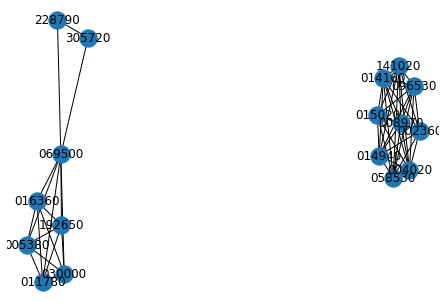

In [ ]:
g = nx.from_pandas_edgelist(a, 'source', 'target', create_using = nx.Graph())
nx.draw(g, with_labels=True)
# print(nx.info(g))
dgr = nx.degree_centrality(g)        # 연결 중심성
btw = nx.betweenness_centrality(g)   # 매개 중심성
cls = nx.closeness_centrality(g)     # 근접 중심성
egv = nx.eigenvector_centrality(g)   # 고유벡터 중심성
pgr = nx.pagerank(g)                 # 페이지 랭크

sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
sorted_btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)
sorted_cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)
sorted_egv = sorted(egv.items(), key=operator.itemgetter(1), reverse=True)
sorted_pgr = sorted(pgr.items(), key=operator.itemgetter(1), reverse=True)

G = nx.Graph()

for i in range(len(sorted_dgr)):
    G.add_node(sorted_pgr[i][0], nodesize=sorted_dgr[i][1])

# for ind in range((len(np.where(dataset['freq'] > 20000)[0]))):
#     G.add_weighted_edges_from([(dataset['word1'][ind], dataset['word2'][ind], int(dataset['freq'][ind]))])

# 노드 크기 조정
sizes = [G.nodes[node]['nodesize'] * 500 for node in G]

options = {
    'edge_color': '#FFDEA2',
    'width': 1,
    'with_labels': True,
    'font_weight': 'regular',
}



In [ ]:


# plt.figure(figsize=(20, 20))
# pos = nx.spring_layout(g, k = 0.15)
# nx.draw_networkx(g,pos, node_size = 25, node_color = 'blue')
# plt.show()